# Rewriting/Reorganizing the codebase for EnKF

## Farsite

### Config File

In [24]:
from putils import get_observation, plot_geometry, plot_matrix
from dautils import sample_winddirection, sample_windspeed, validate_geom, adjusted_state_EnKF_farsite, geom_to_state, align_states, return_ws_wd
from futils import forward_pass_farsite, generate_landscape

from shapely import Polygon

import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm

import pickle
import datetime
import os
import contextily as ctx

import geopandas as gpd
import pandas as pd

### Testing EnKF

In [34]:
description = 'Bridge2021'

for tix in tqdm(range(10)):
    try:
        obs, ts = get_observation(description, tix)
    except Exception as e:
        print(e)
        print(f'No observation found for tix={tix}')
        break

tfin = tix

 60%|██████    | 6/10 [00:00<00:00,  7.02it/s]

'/home/tcaglar/farsite-devAPI/inputs/landscapes/Bridge2021.lcp' not recognized as a supported file format.
No observation found for tix=6


In [35]:
if description == 'Maria2019':
    # MAria Fire wind values
    # Windspeed and Wind direction that were used live
    wslst = [11, 18, 18, 25, 17, 22, 15, 12, 14, 14, 14]
    wdlst = [37, 48, 48, 44, 16, 29, 19, 24, 22, 21, 20]
    print('Chose Maria fire')
elif description == 'Bridge2021':
    # Bridge fire wind values
    wslst = [15]*(tfin)
    wdlst = [270]*(tfin)
    print('Chose Bridge fire')
elif description == 'CA-FKU-BOLT':
    # Bridge fire wind values
    wslst = [15]*(tfin)
    wdlst = [0]*(tfin)
    print('Chose CA-FKU-BOLT fire')
elif description == 'CA-FKU-FLASH':
    # Bridge fire wind values
    wslst = [15]*(tfin)
    wdlst = [200]*(tfin)
    print('Chose CA-FKU-FLASH fire')

# River fire wind values
# wslst = [15]*(tfin)
# wdlst = [215]*(tfin)

n_vertex = 50
n_samples = 1000
vsize=100  # Observation uncertainty
wsize=100   # Model uncertainty
rng = np.random.Generator(np.random.PCG64(1234))

observations = []
timestamps = []

for tix in tqdm(range(tfin)):
    obs, ts = get_observation(description, tix)
    observations.append(obs)
    timestamps.append(ts)

Chose Bridge fire


100%|██████████| 6/6 [00:00<00:00,  6.99it/s]


2021-09-05 14:04:52
0 days 00:00:00
0 days 00:29:37
0 days 00:57:24
0 days 01:20:28
0 days 01:53:35
0 days 02:18:39


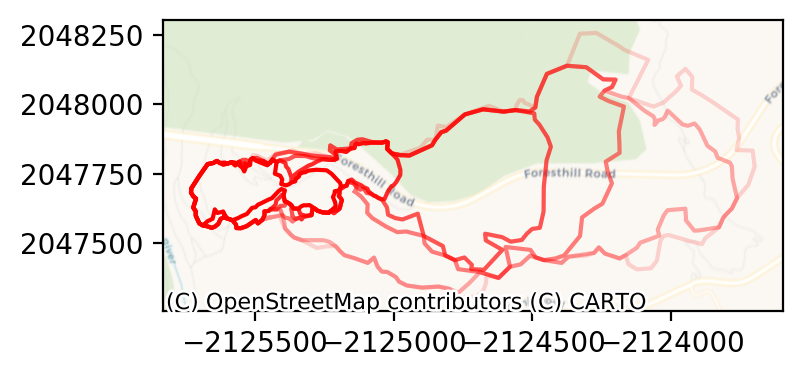

In [36]:
fig, ax = plt.subplots(1,1, figsize=(4,4), dpi=200)

print(timestamps[0])
for i, (geom, dt) in enumerate(zip(observations, timestamps)):
    plot_geometry(validate_geom(geom), ax=ax, color='red', alpha=1-i/len(observations))
    print(dt - timestamps[0])

    
lcppath = generate_landscape(observations[0], description=description)    
# Maria boundaries
# ax.set_xlim(-2.091e6, -2.081e6)
# ax.set_ylim(1.498e6, 1.508e6)

# # Bridge boundaries
# ax.set_xlim(-2.1260e6, -2.1235e6)
# ax.set_ylim(2.0470e6, 2.0485e6)

# River boundaries
# ax.set_xlim(-2.1260e6, -2.1235e6)
# ax.set_ylim(2.0470e6, 2.0485e6)


ctx.add_basemap(ax=ax, source=ctx.providers.CartoDB.Voyager, crs='EPSG:5070')

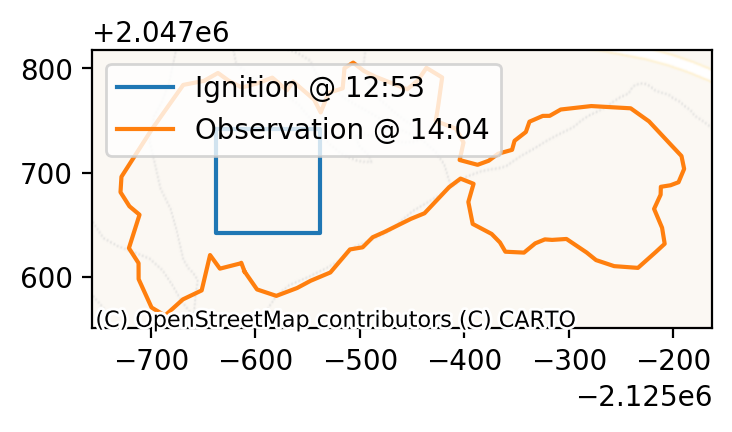

In [37]:
if description == 'Maria2019':
    # Maria ignition
    ignition_timepoint = timestamps[0].replace(hour=19, minute=0)
    x,y = (-2084217.1484733422, 1503560.461310427)
    width = 200
    xshift = 2000
    yshift = 1500
elif description == 'Bridge2021':
    # Bridge2021 ignition
    ignition_timepoint = timestamps[0].replace(hour=12, minute=53)
    x,y = observations[0].centroid.x, observations[0].centroid.y
    width = 100
    xshift = -50
    yshift = 50
elif description == 'CA-FKU-BOLT':
    ignition_timepoint = timestamps[0].replace(hour=0, minute=0, second=0, microsecond=0)
    x,y = observations[0].centroid.x, observations[0].centroid.y
    width = 100
    xshift = 250
    yshift = 350
elif description == 'CA-FKU-FLASH':
    ignition_timepoint = timestamps[0].replace(hour=0, minute=0, second=0, microsecond=0)
    x,y = observations[0].centroid.x, observations[0].centroid.y
    width = 100
    xshift = -250
    yshift = -350

# River2021 ignition
# ignition_timepoint = timestamps[0].replace(hour=14, minute=0)
# x,y = x,y = observations[0].centroid.x, observations[0].centroid.y
# width = 100
# xshift = -1200
# yshift = -2000

x += xshift
y+= yshift
ignition = Polygon([(x-width, y), (x, y), (x,y-width), (x-width, y-width)])

fig, ax = plt.subplots(1,1, figsize=(4,4), dpi=200)
plot_geometry(ignition, ax=ax, label=f'Ignition @ {ignition_timepoint.strftime("%H:%M")}')
plot_geometry(observations[0], ax=ax, label=f'Observation @ {timestamps[0].strftime("%H:%M")}')
ax.legend(loc='upper left')

model_output_lst = []
adjusted_geom_lst = []
adjusted_wx_lst = []
adjusted_wy_lst = []
X_lst = []
xkhat_ensemble_lst = []
xkphat_ensemble_lst = []
ykhat_ensemble_lst = []
zkphat_ensemble_lst = []

ctx.add_basemap(ax=ax, source=ctx.providers.CartoDB.Voyager, crs='EPSG:5070')

In [38]:
# Run farsite from ignition to the first observation
dt = timestamps[0] - ignition_timepoint
wd = wdlst[0]
ws = wslst[0]
params = {'windspeed': ws,'winddirection': wd,'dt': dt}
dist_res = 150
perim_res = 150

wssigma = 3

model_output = forward_pass_farsite(ignition, params=params,
                                   lcppath=lcppath, description=description,
                                    dist_res=dist_res, perim_res=perim_res)
model_output_lst.append(model_output)

###########################################
#### CALCULATE ADJUSTED MODEL OUTPUT ######
###########################################
# Input of data assimilation
n_states = 2*n_vertex  + 2
n_output = n_states
tix = 0
wx = ws*np.cos(wd*np.pi/180)
wy = ws*np.sin(wd*np.pi/180)
initial_state = geom_to_state(ignition, wx, wy)
observation_state = geom_to_state(validate_geom(observations[tix]), wx, wy)

X = np.zeros((n_states, n_states))
X[:(2*n_vertex), :(2*n_vertex)] = 1e3*np.eye(2*n_vertex)  # Initial covariance matrix
X[(2*n_vertex):, (2*n_vertex):] = np.eye(2)  # Initial covariance matrix
# X = 1e3*np.eye(2*n_vertex)

initial_state, observation_state = align_states([initial_state, observation_state], vertex_count=n_vertex)
adjusted_state, X, zkphat_ensemble, xkhat_ensemble, ykhat_ensemble, xkphat_ensemble = adjusted_state_EnKF_farsite(
    initial_state, observation_state, wssigma, X, n_states, n_output, n_vertex, n_samples, 
    rng, dt, vsize, wsize, 
    description, dist_res, perim_res)

adjusted_geom = validate_geom(Polygon(zip(adjusted_state[:-2:2], adjusted_state[1:-2:2])))
adjusted_geom_lst.append(adjusted_geom)

wshat, wdhat = return_ws_wd(adjusted_state)
wsmean = wshat.mean()
wdmean = wdhat.mean()
wxmean = wsmean*np.cos(wdmean*np.pi/180)
wymean = wsmean*np.sin(wdmean*np.pi/180)

adjusted_wx_lst.append(wxmean)
adjusted_wy_lst.append(wymean)

X_lst.append(X)
xkhat_ensemble_lst.append(xkhat_ensemble)
xkphat_ensemble_lst.append(xkphat_ensemble)
ykhat_ensemble_lst.append(ykhat_ensemble)
zkphat_ensemble_lst.append(zkphat_ensemble)

100%|██████████| 1000/1000 [07:28<00:00,  2.23it/s]


Calculating 49/50..    
Calculating 49/50..    


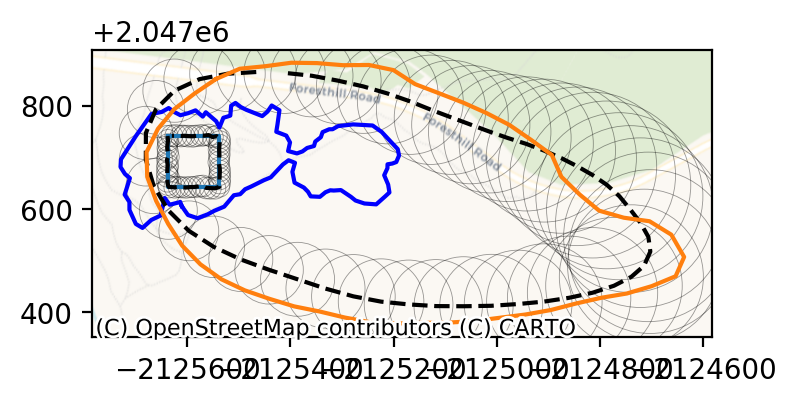

In [39]:
# X=1e1
fig, ax = plt.subplots(1,1, figsize=(4,4), dpi=200)
plot_geometry(ignition, ax=ax)
plot_geometry(observations[0], ax=ax, color='blue')
# plot_geometry(adjusted_geom, ax=ax, color='blue', ls='--')
plot_matrix(xkhat_ensemble[:-2,:], ax=ax, color='black', ls='--', show_stdev=True)
plot_matrix(zkphat_ensemble[:-2,:], ax=ax, color='black', ls='--', show_stdev=True)
# plot_matrix(xkphat_ensemble, ax=ax, color='black', ls='--', show_stdev=True)
plot_geometry(validate_geom(adjusted_geom), ax=ax)
# plot_matrix_ensemble(zkphat_ensemble, ax=ax, color=(0,0,0,0.1), lw=1, plot_alix=5)

ctx.add_basemap(ax=ax, source=ctx.providers.CartoDB.Voyager, crs='EPSG:5070')

(array([  4.,  16.,  62., 159., 283., 284., 141.,  43.,   7.,   1.]),
 array([17.55258714, 20.18944205, 22.82629695, 25.46315186, 28.10000676,
        30.73686167, 33.37371658, 36.01057148, 38.64742639, 41.2842813 ,
        43.9211362 ]),
 <a list of 10 Patch objects>)

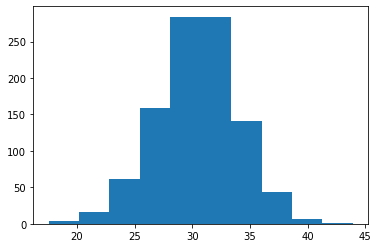

In [32]:
wshat, wdhat = return_ws_wd(xkphat_ensemble)

wsmean = wshat.mean()
wdmean = wdhat.mean()
wxmean = wsmean*np.cos(wdmean*np.pi/180)
wymean = wsmean*np.sin(wdmean*np.pi/180)

plt.hist(wshat)



Calculating 49/50..    
Calculating 49/50..    


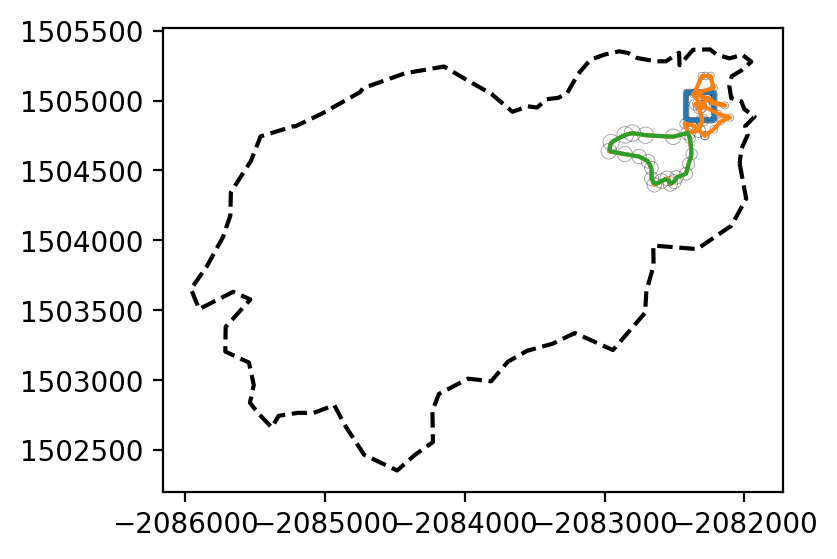

In [33]:
fig, ax = plt.subplots(1,1, figsize=(4,4), dpi=200)
plot_matrix(xkhat_ensemble[:-2,:], ax=ax, show_stdev=True)
plot_matrix(xkphat_ensemble[:-2,:], ax=ax, show_stdev=True)
plot_geometry(adjusted_geom, ax=ax)
plot_geometry(observations[1], ax=ax, color='black', linestyle='--')

In [10]:
%%time

# Run farsite for the rest of the time
for tix in range(1,tfin):
    print(f'\nCalculating {tix}/{tfin}...')
    dt = timestamps[tix] - timestamps[tix-1]
    wd = wdlst[tix]
    ws = wslst[tix]
    wx = ws*np.cos(wd*np.pi/180)
    wy = ws*np.sin(wd*np.pi/180)
    
    dist_res = int(validate_geom(observations[tix-1]).exterior.length/n_vertex)
    perim_res = dist_res
    
    print('calculating model')
    model_output = forward_pass_farsite(observations[tix-1], {'windspeed': ws,
                                                         'winddirection': wd,
                                                         'dt': dt},
                                        lcppath=lcppath, description=description,
                                    dist_res=dist_res, perim_res=perim_res)
    model_output_lst.append(model_output)
    print('model done')
    
    ###########################################
    #### CALCULATE ADJUSTED MODEL OUTPUT ######
    ###########################################
    print('initial state')
    
    wshat, wdhat = return_ws_wd(adjusted_state)
    wsmean = wshat.mean()
    wdmean = wdhat.mean()
    wxmean = wsmean*np.cos(wdmean*np.pi/180)
    wymean = wsmean*np.sin(wdmean*np.pi/180)
    print('ws_adjusted = ', wsmean, 'wd_adjusted = ', wdmean)
    
    
    initial_state = geom_to_state(adjusted_geom_lst[tix-1], wxmean, wymean)
    print('observation state')
    observation_state = geom_to_state(validate_geom(observations[tix]), wx, wy)
    
    print('align states')
    initial_state, observation_state = align_states([initial_state, observation_state], vertex_count=n_vertex)
    print('enkf start')
    adjusted_state, X, zkphat_ensemble, xkhat_ensemble, ykhat_ensemble, xkphat_ensemble = adjusted_state_EnKF_farsite(
        initial_state, observation_state, wssigma, X, 
        n_states, n_output, n_vertex, n_samples, rng, dt,
        vsize, wsize, description,
        dist_res, perim_res)
    print('enkf end')
    adjusted_geom = validate_geom(Polygon(zip(adjusted_state[:-2:2], adjusted_state[1:-2:2])))
    adjusted_geom_lst.append(adjusted_geom)
    
    wshat, wdhat = return_ws_wd(adjusted_state)
    wsmean = wshat.mean()
    wdmean = wdhat.mean()
    wxmean = wsmean*np.cos(wdmean*np.pi/180)
    wymean = wsmean*np.sin(wdmean*np.pi/180)
    
    adjusted_wx_lst.append(wxmean)
    adjusted_wy_lst.append(wymean)
    
    X_lst.append(X)
    xkhat_ensemble_lst.append(xkhat_ensemble)
    xkphat_ensemble_lst.append(xkphat_ensemble)
    ykhat_ensemble_lst.append(ykhat_ensemble)
    zkphat_ensemble_lst.append(zkphat_ensemble)


Calculating 1/9...
calculating model
model done
initial state
ws_adjusted =  12.807296826635804 wd_adjusted =  307.5880652988974
observation state
align states
enkf start


100%|██████████| 250/250 [00:43<00:00,  5.74it/s]


enkf end

Calculating 2/9...
calculating model
model done
initial state
ws_adjusted =  9.20732218028164 wd_adjusted =  352.07826103768826
observation state
align states
enkf start


100%|██████████| 250/250 [00:19<00:00, 12.83it/s]
/home/tcaglar/farsite-devAPI/src/housecleaning/dautils.py:227: RuntimeWarning: invalid value encountered in divide
  zkphat_mean = zkphat_ensemble.sum(axis=1, keepdims=True)/(n_samples - len(zero_samples))


GEOSException: IllegalArgumentException: Points of LinearRing do not form a closed linestring

array([9.20732218])

NameError: name 'zero_samples' is not defined

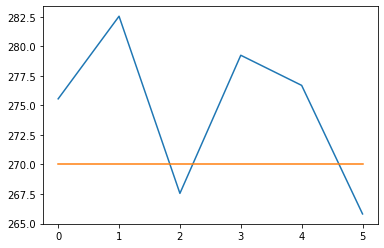

In [24]:
wx = np.array(adjusted_wx_lst)
wy = np.array(adjusted_wy_lst)

ws = np.sqrt(wx**2 + wy**2)
wd = np.fmod((180/np.pi)*np.arctan2(wy,wx) + 360,360)

plt.plot(range(tfin), wd)
plt.plot(range(tfin), wdlst)

In [15]:
fname = f'{description}_results_{datetime.datetime.today().strftime("%m%d%Y")}_vsz{vsize}_wsz{wsize}.pkl'
fpath = os.path.join(os.getenv('HOME'), 'farsite-devAPI', 'data', fname)

data = {'adjusted_geom': adjusted_geom_lst,
        'xkhat_ensemble_lst': xkhat_ensemble_lst,
        'xkphat_ensemble_lst': xkphat_ensemble_lst,
        'ykhat_ensemble_lst': ykhat_ensemble_lst,
        'zkphat_ensemble_lst': zkphat_ensemble_lst,
        'X_lst': X_lst}
with open(fpath, 'wb') as f:
    pickle.dump(data, f)

print(f'Saved file to {fpath}')

Saved file to /home/tcaglar/farsite-devAPI/data/Bridge2021_results_09302024_vsz100_wsz100.pkl


## Test

In [3]:
gdf = gpd.read_file('/home/tcaglar/farsite-devAPI/data/intterra_firis.geojson')
gdfMetadataDropped = gdf.dropna(subset='metadata')

In [4]:
gdf = gpd.read_file('/home/tcaglar/farsite-devAPI/data/intterra_firis.geojson')
gdfMetadataDropped = gdf.dropna(subset='metadata')

gdf = gpd.read_file('/home/tcaglar/farsite-devAPI/data/intterra_firis.geojson')
def fill_json(kw):
    if kw['json']['source'] == None:
        return ''
    return kw['json']['source']
        
gdf['source'] = gdf.apply(fill_json, axis=1)

In [7]:
fires = ['CA-FKU-BOLT', 'CA-FKU-FLASH', 'CA-LAC-POST', 'CA-SCU-CORRAL']

gdfFiltered = gdf[gdf['source'].str.contains(fires[0])].sort_values('created_time').to_crs(epsg=5070)
gdfFiltered['created_time'] = pd.to_datetime(gdfFiltered['created_time'])
gdfFiltered['created_time'].diff()

ignition = gdfFiltered['geometry'].iloc[0]

# indices = [11970, 11974, 11982, 11984, 11997, 12008]
# gdfFiltered = gdfFiltered.loc[indices].to_crs(epsg=5070)

In [7]:
geom, tp = get_observation('CA-FKU-BOLT', 5)

IndexError: single positional indexer is out-of-bounds

In [24]:
gdfFiltered

,id,created_time,json,metadata,geometry,source
12055,12091,2024-06-25 01:16:51.159000+00:00,"{'test': None, 'type': 'PERIM', 'source': 'CA-...","{'dpa': 'STATE', 'agency': 'FKU', 'county': 'F...","POLYGON ((-2041209.968 1778975.744, -2041262.2...",CA-FKU-BOLT-N43U
12061,12102,2024-06-25 08:28:51.105999+00:00,"{'test': None, 'type': 'PERIM', 'source': 'CA-...","{'dpa': 'STATE', 'agency': 'FKU', 'county': 'F...","POLYGON ((-2040752.226 1778994.053, -2040693.8...",CA-FKU-BOLT-N43U
12070,12110,2024-06-25 19:47:51.359001+00:00,"{'test': None, 'type': 'PERIM', 'source': 'CA-...","{'dpa': 'STATE', 'agency': 'FKU', 'county': 'F...","POLYGON ((-2041575.246 1775921.422, -2041500.1...",CA-FKU-BOLT-N43U
12076,12116,2024-06-26 09:04:51.273998+00:00,"{'test': None, 'type': 'PERIM', 'source': 'CA-...","{'dpa': 'STATE', 'agency': 'FKU', 'county': 'F...","POLYGON ((-2037996.835 1772475.883, -2037942.0...",CA-FKU-BOLT-N57B


In [6]:
tp

Timestamp('2024-06-25 01:16:51.159000+0000', tz='UTC')

FARSITE INPUTS FILE VERSION 1.0
FARSITE_START_TIME: 9 9 1900
FARSITE_END_TIME: 9 9 2200
FARSITE_TIMESTEP: 180
FARSITE_DISTANCE_RES: 120
FARSITE_PERIMETER_RES: 240
FARSITE_MIN_IGNITION_VERTEX_DISTANCE: 15.0
FARSITE_SPOT_GRID_RESOLUTION: 60.0
FARSITE_SPOT_PROBABILITY: 0
FARSITE_SPOT_IGNITION_DELAY: 0
FARSITE_MINIMUM_SPOT_DISTANCE: 60
FARSITE_ACCELERATION_ON: 1
FARSITE_FILL_BARRIERS: 1
SPOTTING_SEED: 253114
FUEL_MOISTURES_DATA: 1
0 3 4 6 30 60
RAWS_ELEVATION: 2501
RAWS_UNITS: English
RAWS: 1
2019 9 9 1900 66 8 0 15 0 0
FOLIAR_MOISTURE_CONTENT: 100
CROWN_FIRE_METHOD: ScottReinhardt
WRITE_OUTPUTS_EACH_TIMESTEP: 0


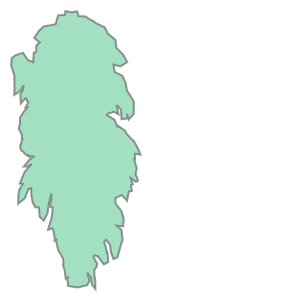

CPU times: user 40.2 ms, sys: 417 µs, total: 40.6 ms
Wall time: 1 s


In [105]:
%%time

params = {'windspeed': ws, 'winddirection': wd, 'dt': datetime.timedelta(minutes=180)}
# forward_geom = forward_pass_farsite(ignition, params, lcppath, 'POST')
# display(forward_geom)
farsite = Farsite(ignition, params, 'POST', lcppath, dist_res=120, perim_res=240)
print(farsite.config.tostring())

farsite.run()
display(farsite.output_geom())

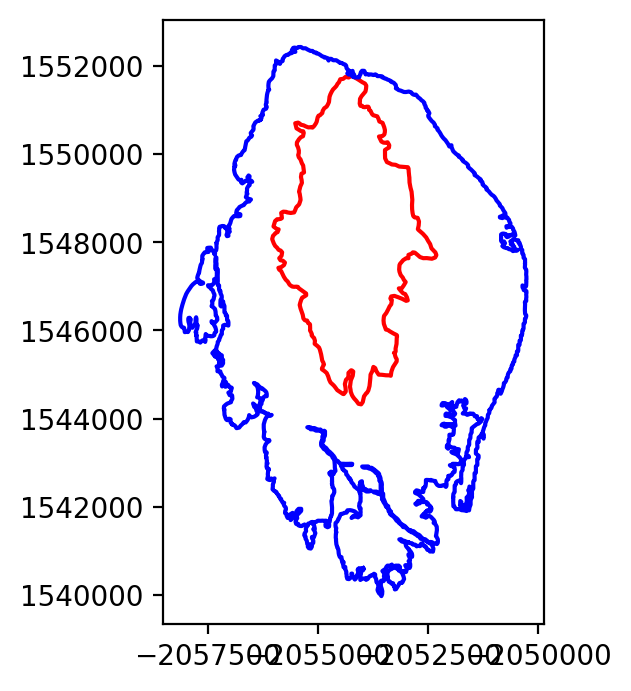

In [213]:
fig, ax = plt.subplots(1,1, figsize=(4,4), dpi=200)
plot_geometry(ignition, ax=ax, color='red')
plot_geometry(forward_geom, ax=ax, color='blue')

In [86]:
gdfFiltered['created_time'].diff()

11970                      NaT
11974   0 days 00:51:00.193001
11975   0 days 00:00:01.632999
11960   0 days 00:00:01.246003
11982   0 days 07:01:57.187999
11968   0 days 00:00:01.748001
11971   0 days 00:00:02.170998
11984   0 days 10:31:56.311001
11985   0 days 00:00:01.777000
11913   0 days 00:00:01.932999
11986   0 days 00:00:01.871002
11997   0 days 07:00:54.410999
11998   0 days 00:00:01.672001
11999   0 days 00:00:01.985001
12008   0 days 16:28:56.179996
12009   0 days 00:00:01.766003
12010   0 days 00:00:02.148998
Name: created_time, dtype: timedelta64[ns]

In [82]:
%%time

ignition = gdfFiltered['geometry'].iloc[0]
ws = 15
wd = 0
dt = datetime.timedelta(minutes=30)

lcppath = generate_landscape(ignition, 'POST')
forward_geom = forward_pass_farsite(ignition, params=params,
                                    lcppath=lcppath, description='POST')

CPU times: user 137 ms, sys: 12 ms, total: 149 ms
Wall time: 4.72 s


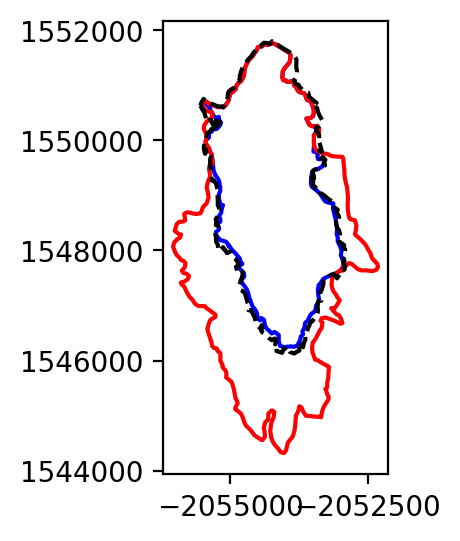

In [83]:
fig, ax = plt.subplots(1,1, figsize=(4,3), dpi=200)
plot_geometry(ignition, color='b', ax=ax)
plot_geometry(gdfFiltered['geometry'].iloc[1], color='r', ax=ax)
plot_geometry(forward_geom, color='k', ax=ax, ls='--')

['CA-FKU-BOLT', 'CA-FKU-FLASH', 'CA-LAC-POST', 'CA-SCU-CORRAL']

In [105]:
from dsfunctions import plot_geometry

11970    None
11974    None
11975    None
11960    None
11982    None
11968    None
11971    None
11984    None
11985    None
11913    None
11986    None
11997    None
11998    None
11999    None
12008    None
12009    None
12010    None
dtype: object

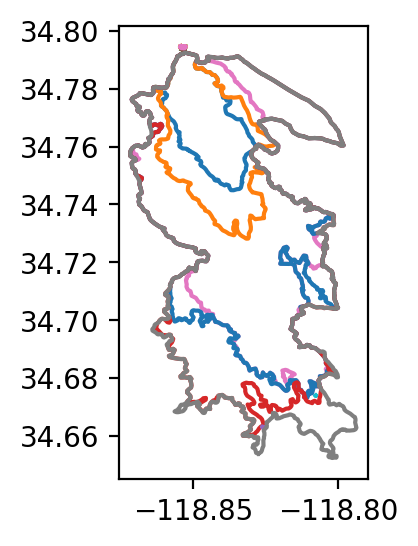

In [113]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(1,1, figsize=(4,3), dpi=200)

gdf[gdf['source'].str.contains('CA-LAC-POST')].sort_values('created_time').apply(lambda row: plot_geometry(row['geometry'], ax=ax), axis=1)

In [ ]:
ws = 15
wd = 0


In [103]:
import pandas as pd
pd.to_datetime(gdf[gdf['source'].str.contains('CA-FKU-BOLT')].sort_values('created_time')['created_time'])

12055   2024-06-25 01:16:51.159000+00:00
12061   2024-06-25 08:28:51.105999+00:00
12070   2024-06-25 19:47:51.359001+00:00
12076   2024-06-26 09:04:51.273998+00:00
Name: created_time, dtype: datetime64[ns, UTC]

In [51]:
# def select_
gdfMetadataDropped['json'].apply(lambda kw: kw['source'].startswith('CA-FKU-BOLT'))

AttributeError: 'NoneType' object has no attribute 'startswith'

In [28]:
gdfFiltered[gdfFiltered['metadata'].apply(lambda kw: (kw['agency']=='FKU'))]['metadata'].apply(lambda kw: kw['county'])

10873    Fresno
10874    Fresno
11019    Fresno
11020    Fresno
11028    Fresno
11131    Fresno
11132    Fresno
11292    Fresno
11295    Fresno
11359    Fresno
11361    Fresno
11362    Fresno
11727     Kings
11740     Kings
11741     Kings
11839    Fresno
11864    Fresno
11875    Fresno
11909    Fresno
11916    Fresno
11923     Kings
11948    Fresno
11949    Fresno
11950    Fresno
11952    Fresno
11953    Fresno
11954    Fresno
11955    Fresno
12041    Fresno
12049    Fresno
12050    Fresno
12055    Fresno
12061    Fresno
12065    Fresno
12069    Fresno
12070    Fresno
12071    Fresno
12072    Fresno
12074    Fresno
12075    Fresno
12076    Fresno
Name: metadata, dtype: object

In [26]:
gdf['metadata'].iloc[0]

{'dpa': 'STATE',
 'agency': 'BEU',
 'county': 'San Benito',
 'region': 'CA',
 'oes_region': '2'}